In [12]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

In [13]:
import numpy as np
import math
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sympy import *
from scipy.stats import bernoulli

%matplotlib inline

## The simultaneous perturbation stochastic approximation (SPSA) algorithm 

Here we present the standard (first-order) simultaneous perturbation stochastic approximation (SPSA) algorithm. The basic idea of the algorithm is shown in the figure below<sup>1</sup>:


<div>
<img src="SPSA.png"/>
</div>


The algorithm is similar to gradient descent, but instead of using the gradient, we use a "simultaneous perturbation" estimate. If $E$ is our objective function and $\theta$ is the vector of variables we are minimizing over, the picture shows the value of $\theta$ at iteration $k$, $\theta_k$ and how the iterate $\theta_{k+1}$ is calculated. The direction of the next step is randomly selected from a Bernoulli distribution of $\pm 1$ values. Note that we can use other distributions but need to specify certain criteria for convergence of the algorithm; normal and uniform do not<sup>2</sup>. If $\Delta_k$ represents the randomly selected vector of $\pm 1$, the algorithm calculates two values $\theta_k^-$ and $\theta_k^+$ as follows:
$$\theta_k^- = \theta_k- c_k  \Delta_k \ \ , \ \ \ \theta_k^+ = \theta_k+ c_k  \Delta_k$$
where $c_k=\frac{c}{k^\gamma}$ is an iteration-adjusted parameter. The fact that all components of the $\theta$ vector are perturbed at the same time gives the simultaneous perturbation name to the algorithm. The function values at these two points are used to calculate the gradient:
$$g_k=\frac{E(\theta_k^+)-E(\theta_k^-)}{2c_k} \Delta_k$$
Note that we need only two measurements of $E$ per iteration. Also, these measurements may not be accurate, but as long as the difference $E(\theta_k^+)-E(\theta_k^-)$ is larger than any error $\epsilon_k$ in the measurement, the algorithm will work. Having estimated the gradient $g_k$ we can get a new $\theta$:
$$\theta_{k+1} = \theta_k - a_k g_k(\theta_k)$$
where $a_k=\frac{a}{(k+A)^\alpha}$ is an iteration-adjusted parameter. 

To summarize, the algorithm works as follows:
1. Select parameters $a$, $c$, $A$, $\alpha$, $\gamma$.
2. Select an initial guess for $\theta$ and set iteration $k=0$.
3. Update $a_k$ and $c_k$.
4. Draw a random vector $\Delta$ from a Bernoulli $\pm 1$ distribution. 
5. Calculate $\theta^-$ and $\theta^+$.
6. Calculate the function values at $\theta^-$ and $\theta^+$. If the value is larger than a threshold, discard the iteration, set $k=k+1$, and go back to Step 3.
7. Calculate the new gradient $g_k$ and the new $\theta$.
8. If the new $\theta$ is too far from the previous one, discard the iteration, set $k=k+1$, and go back to Step 3. 
9. Otherwise, update the $\theta$, set $k=k+1$, and go back to Step 3.

The algorithm is very sensitive to the parameter settings, which need to be calibrated and must fulfill certain conditions to guarantee convergence. For discussions about how to calibrate, see the papers cited previously<sup>1</sup><sup>, </sup><sup>2</sup>. 

Next, we will walk through an example. We start with the Rosenbrock function using `sympy`. We assume that our measurements of the function are accurate (not noisy). You can add an error to these as described in the previous references<sup>1</sup><sup>, </sup><sup>2</sup>. 

In [3]:
x1,x2=symbols("x1 x2")
f=Matrix([100*(x2-x1**2)**2+(1-x1)**2])
X=Matrix([x1,x2])
f

Matrix([[(1 - x1)**2 + 100*(-x1**2 + x2)**2]])

Following the suggestions in the referenced publications<sup>1</sup><sup>, </sup><sup>2</sup>, to set the initial parameters, we run the algorithm below until the changes in $\theta$ are not significant (as defined by the $\epsilon$ parameter). Changing the parameters will change the behavior of the algorithm. You can set the number of iterations $n$ and run as many as needed to converge. Given the dependence of $a_k$ and $c_k$ on the current iteration $k$, the algorithm may not change $\theta$ for many iterations, so the condition in the `while` loop below may not always signify convergence. 

In [4]:
n=1000
fv=lambdify((x1,x2),100*(x2-x1**2)**2+(1-x1)**2)
A=300.
alpha=0.502
gamma=0.101
a=0.077
c=0.01
theta=[0,0]
gr=np.empty(2)
ftol=10000
epsilon=0.0000000001
k=1 
dtheta=[1,1]
plx=[theta[0]]
ply=[theta[1]]
while (np.linalg.norm(dtheta) > epsilon):
    a_k=a/((k+A)**alpha)
    c_k=c/(k**gamma)
    delta=2*np.round(np.random.binomial(size=2,p=0.5,n=1))-1
    thetap=theta+c_k*delta
    thetam=theta-c_k*delta
    yp=fv(thetap[0],thetap[1])
    ym=fv(thetam[0],thetam[1])
    grc=(yp-ym)/(2*c_k)
    gr[0]=grc/delta[0]
    gr[1]=grc/delta[1]
    prevf=fv(theta[0],theta[1])
    newtheta=theta-a_k*gr
    if (abs(fv(newtheta[0],newtheta[1])-prevf) < ftol):
        dtheta= newtheta-theta
        if (np.linalg.norm(dtheta) < 10):
            theta=newtheta
    k=k+1
    if (100*int(k/100) == k):
        plx.append(theta[0])
        ply.append(theta[1])
print('Terminated after ',k,' iterations with theta: ',theta)


Terminated after  11437  iterations with theta:  [0.9958847  0.99178773]


The figure below shows the progress of the algorithm every 100 iterations. We see that, as expected, the direction of the path is not always improving the objective function.

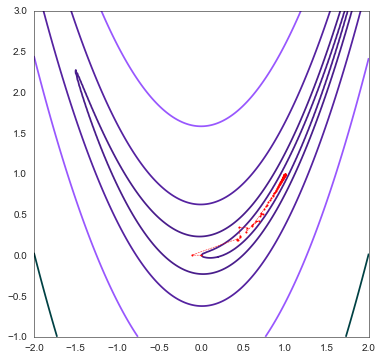

In [5]:
from scipy.optimize import rosen
npts = 201
x, y = np.mgrid[-2:2:npts*1j, -1:3:npts*1j]
x.shape = (npts**2)
y.shape = (npts**2)
z = rosen(np.vstack((x, y)))
x.shape = (npts, npts)
y.shape = (npts, npts)
z.shape = (npts, npts)
fig = plt.figure(figsize=(6,6))
ax1 = fig.subplots()
# Plots/
levels = np.logspace(0, 3.2, 5)
#plt.cla()
ax1.contour(x, y, z, levels)
ax1.plot(plx,ply,'ro--',markersize=2,linewidth=0.5)

## Calling the SPSA algorithm in Qiskit

First we import the `SPSA` package from `qiskit_algorithms.optimizers`.

In [6]:
from qiskit_algorithms.optimizers import SPSA

We define the function as a method accepting a two-dimensional vector.

In [7]:
def func(x):
   return 100*(x[1]-x[0]**2)**2+(1-x[0])**2

Due to the random selection of the perturbation vector, we run 10 tries each time to get a better idea of the performance. 

First we run with a 20,000 iteration limit and the starting point `[1,0]`, and we don't get very close to the optimum. Note that the result is a tuple consisting of a `numpy array` which is the best point, followed by the objective value and the number of calls to the function.

In [8]:
spsa=SPSA(maxiter=20000)
initial_point=[1,0]
best=10000
pll=[]
plx=[]
ply=[]
for _ in range(10):
    result = spsa.optimize(2, func,initial_point=initial_point )
    if (result[1] < best):
        best=result[1]
        bx=result[0][0]
        by=result[0][1]
    print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('20K')
plx.append(bx)
ply.append(by)

Minimum of:  0.3672430433073597  at:  [0.39453193 0.15820782] .
Minimum of:  1.2955106966643328  at:  [-0.13497615  0.02678585] .
Minimum of:  0.11318954360658481  at:  [0.6657567 0.4470673] .
Minimum of:  0.3100737427477463  at:  [0.44380601 0.19965075] .
Minimum of:  1.070923569294326  at:  [-0.03285792  0.00750466] .
Minimum of:  0.36797121537529537  at:  [0.39391956 0.15769791] .
Minimum of:  0.2987075117550772  at:  [0.45413751 0.2089642 ] .
Minimum of:  0.31049734343725055  at:  [0.44342499 0.19931198] .
Minimum of:  0.8627642974755168  at:  [0.07217274 0.00956879] .
Minimum of:  1.725925851841348  at:  [-0.30880959  0.10674023] .


By enabling blocking (disregarding changes bigger than the threshold), we get a similar solution, still not close enough to the optimal.

In [9]:
spsa=SPSA(maxiter=20000,blocking=True)
initial_point=[1,0]
for _ in range(10):
    result = spsa.optimize(2, func,initial_point=initial_point )
    if (result[1] < best):
        best=result[1]
        bx=result[0][0]
        by=result[0][1]
    print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('20KB')
plx.append(bx)
ply.append(by)

Minimum of:  0.6149883620100185  at:  [0.21626453 0.04950362] .
Minimum of:  0.2888303045891557  at:  [0.4632879  0.21741132] .
Minimum of:  0.11330760117587922  at:  [0.66342737 0.43962142] .
Minimum of:  0.31706181809760425  at:  [0.43754355 0.19409871] .
Minimum of:  0.29470876213459896  at:  [0.45782286 0.21234532] .
Minimum of:  0.24939995421835334  at:  [0.50147075 0.25442001] .
Minimum of:  0.11082753824202508  at:  [0.66738568 0.44400632] .
Minimum of:  0.3015538621645939  at:  [0.45152519 0.20657544] .
Minimum of:  0.366909637286334  at:  [0.39480775 0.15842654] .
Minimum of:  0.3508624338679286  at:  [0.40822578 0.16922843] .


Here we use the `calibrate` function, where we can provide the parameters for the algorithm. This will return two generators, one for the learning rates $a_k$, and one for the perturbation rates $c_k$.

In [10]:
lr,pert=spsa.calibrate(func, initial_point, 
               c=0.001, stability_constant=600, 
               target_magnitude=None, 
               alpha=0.502, gamma=0.101, 
               modelspace=False)

In [11]:
spsa=SPSA(maxiter=250000,learning_rate=lr, perturbation=pert,blocking=True)
best=10000
for _ in range(10):
    result=spsa.optimize(2, func,initial_point=initial_point)
    if (result[1] < best):
        best=result[1]
print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('250KCB')
plx.append(result[0][0])
ply.append(result[0][1])

Minimum of:  0.031356425963480185  at:  [0.82309306 0.67670526] .


We increase the maximum iterations to a large number (`2,500,000`) and run four scenarios. We do one run (instead of 10 as before) for each scenario. With the calibration and blocking, we get a good solution. 

In [14]:
spsa=SPSA(maxiter=2500000,learning_rate=lr, perturbation=pert,blocking=True)
result=spsa.optimize(2, func,initial_point=initial_point)
print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('2.5MCB')
plx.append(result[0][0])
ply.append(result[0][1])

Minimum of:  0.001937841978186141  at:  [0.95601618 0.91378623] .


Without blocking, the solution is similar.

In [15]:
spsa=SPSA(maxiter=2500000,learning_rate=lr, perturbation=pert)
result=spsa.optimize(2, func,initial_point=initial_point)
print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('2.5MC')
plx.append(result[0][0])
ply.append(result[0][1])

Minimum of:  0.0018492584392513446  at:  [0.95703317 0.91573614] .


Running with the increased number of iterations but without calibration we get:

In [16]:
spsa=SPSA(maxiter=2500000,blocking=True)
result=spsa.optimize(2, func,initial_point=initial_point)
print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('2.5MB')
plx.append(result[0][0])
ply.append(result[0][1])

Minimum of:  0.07182221627827097  at:  [0.73222363 0.53506502] .


And finally, without blocking or calibration and with an increased number of iterations we get: 

In [17]:
spsa=SPSA(maxiter=2500000)
result=spsa.optimize(2, func,initial_point=initial_point)
print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('2.5M')
plx.append(result[0][0])
ply.append(result[0][1])

Minimum of:  0.06616196440093719  at:  [0.74292167 0.55278525] .


Finally, we calibrate with different values for `c` and the `target_magnitude`, which is used to calculate the $a$ in the $a_k$ formula. The calibration algorithm takes the average values over 25 tries, so below we are effectively setting $a=1$: 

In [18]:
lr,pert=spsa.calibrate(func, initial_point, 
               c=0.01, stability_constant=600, 
               target_magnitude=25, 
               alpha=0.502, gamma=0.101, 
               modelspace=False)

In [19]:
spsa=SPSA(maxiter=15000,learning_rate=lr, perturbation=pert,blocking=True)
best=0
for _ in range(10):
    result=spsa.optimize(2, func,initial_point=initial_point)
    if (result[1] < best):
        best=result[1]
print('Minimum of: ', result[1], ' at: ', result[0], '.')
pll.append('15KCB')
plx.append(result[0][0])
ply.append(result[0][1])

Minimum of:  3.385690218702403e-05  at:  [0.99418728 0.98838204] .


We see that we converge much faster to a better solution (`maxiter` is set to `15,000`):

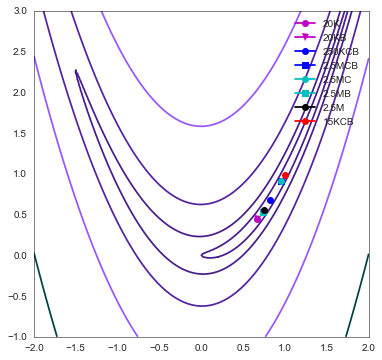

In [20]:
from scipy.optimize import rosen
import itertools
npts = 201
x, y = np.mgrid[-2:2:npts*1j, -1:3:npts*1j]
x.shape = (npts**2)
y.shape = (npts**2)
z = rosen(np.vstack((x, y)))
x.shape = (npts, npts)
y.shape = (npts, npts)
z.shape = (npts, npts)
fig = plt.figure(figsize=(6,6))
ax1 = fig.subplots()
# Plots/
levels = np.logspace(0, 3.2, 5)
#plt.cla()
ax1.contour(x, y, z, levels)
marker = itertools.cycle(('o','v','o','s','o','s','o','o'))
color=itertools.cycle(('m','m','b','b','c','c','k','r'))
for i in range(len(plx)):
    ax1.plot(plx[i],ply[i],color=next(color),marker=next(marker),label=pll[i])
plt.legend(loc='best')


## References
<a id='Kandala2017'></a>1. Kandala, Mezzacapo, Temme, Takita, Brink, Chow, Gambetta, [Hardware-efficient Variational Quantum Eigensolver for Small Molecules and Quantum Magnets](https://arxiv.org/abs/1704.05018). preprint 2017.<br>

<a id='Spall1992'></a>2. Spall, [Multivariate Stochastic Approximation Using a Simultaneous Perturbation Gradient Approximation](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.19.4562). IEEE Transactions on automatic control, 1992. <br>



<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>